In [1]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\envs\tensor

In [2]:
# The paths for the training and validation images
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

#number of images in the training set
num_train_samples = 9013
#number of images in the evaluation set
num_val_samples = 1002
#number of images in every forward/backwards pass
train_batch_size = 10
val_batch_size = 10
#dimensions of the image that will be inputed into the network (224x224)
image_size = 224

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [3]:

# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, #pointing to the path where the data is stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=train_batch_size) #size of the batches

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

Found 38703 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [4]:
# Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# Modify the model
# Choose the 6th layer from the last
x = mobile.layers[-6].output

# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# Prevent everything except the last 23 layers from being trained
for layer in model.layers[:-23]:
    layer.trainable = False

In [5]:
# Define Top2 and Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [7]:
filepath = "skinmodel.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=5,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/5
902/902 [==============================] - 4967s 6s/step - loss: 1.8157 - categorical_accuracy: 0.5173 - top_2_accuracy: 0.7203 - top_3_accuracy: 0.8465 - val_loss: 2.6494 - val_categorical_accuracy: 0.6637 - val_top_2_accuracy: 0.7844 - val_top_3_accuracy: 0.8563

Epoch 00001: val_top_3_accuracy improved from -inf to 0.85629, saving model to skinmodel.h5
Epoch 2/5
902/902 [==============================] - 5668s 6s/step - loss: 1.2757 - categorical_accuracy: 0.6099 - top_2_accuracy: 0.8120 - top_3_accuracy: 0.9172 - val_loss: 1.2227 - val_categorical_accuracy: 0.5369 - val_top_2_accuracy: 0.7764 - val_top_3_accuracy: 0.8832

Epoch 00002: val_top_3_accuracy improved from 0.85629 to 0.88323, saving model to skinmodel.h5
Epoch 3/5
902/902 [==============================] - 5200s 6s/step - loss: 1.1455 - categorical_accuracy: 0.6490 - top_2_accuracy: 0.8373 - top_3_accuracy: 0.9326 - val_loss: 1.7026 - val_categorical_accuracy: 0.4890 - val_top_2_accuracy: 0.7505 - val_top_3_acc

In [6]:
# Evaluation of the best epoch
model.load_weights('skinmodel.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.48456087381302
val_cat_acc: 0.5958083825643191
val_top_2_acc: 0.8113772443341399
val_top_3_acc: 0.9031936121498515


In [7]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

101/101 [==============================] - 2380s 24s/step


In [8]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  0   0   1   3  29   0   0]
 [  0   0   2   7  37   5   0]
 [  0   1   7   4  78  20   0]
 [  0   0   0   9   2   1   0]
 [  0   0   0   6  75  29   1]
 [  0   0   0  32 139 500   0]
 [  0   0   1   1   1   5   6]]


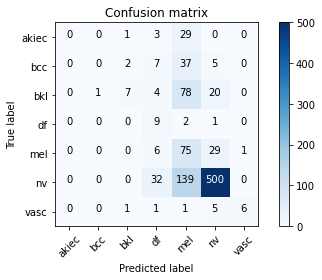

In [9]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)